In [3]:
import os
from matplotlib import pyplot as plt
import random
import pyedflib
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import sys
import scipy.stats as stats
from sklearn.metrics import roc_auc_score
sys.path.append('/home/linzenghui/ECG_code/HeartRateVariability_220217')
import FrequencyDomain as fd
import TimeDomain as td
import NonLinear as nl
from common import *
from Rpeaks import *
names = os.listdir('../polysomnography')
new_names = [name for name in names if name.split('.')[-1] == 'edf']
new_names.sort()
data_frame=pd.read_csv('../datasets/wsc-harmonized-dataset-0.6.0.csv')[['wsc_id','wsc_vst','nsrr_age','nsrr_sex','nsrr_bmi','nsrr_ahi_hp4u_aasm15']]

In [14]:
def resample_interp(ts, fs_in, fs_out):
    """
    基于线性拟合的差值重采样算法
    计算前后点对应的比例进行插值
    :param ts:  单导联数据，一维浮点型数组
    :param fs_in: 原始采样率，整型
    :param fs_out: 目标采样率，整型
    :return: 重采样后的数据
    """
    t = len(ts) / fs_in
    fs_in, fs_out = int(fs_in), int(fs_out)
    if fs_out == fs_in:
        return np.array(ts)
    else:
        x_old = np.linspace(0, 1, num=len(ts), endpoint=True)
        x_new = np.linspace(0, 1, num=int(t * fs_out), endpoint=True)
        y_old = ts
        f = interp1d(x_old, y_old, kind='linear')
        y_new = f(x_new)
        return y_new

In [15]:
def get_wake_time(anno_path):
    with open(anno_path,'r') as f:
        s=f.readlines()
    stage=[line.split('\t')[1] for line in s]
    for i in range(len(stage)):
        if i==0:
            continue
        if (stage[i]!='0')&(stage[i]!='7'):
            break
    return ((i-1)*30,(len(stage)-1)*30)

def get_annopath_from_name(name):
    anno_folder='/data/0shared/linzenghui/ECG_data/public_dataset/wsc/polysomnography/'
    return anno_folder+name.split('.')[0]+'.stg.txt'

In [16]:
def getidx_from_name(name):
    'vst id'
    return(int(name.split('-')[2]),int(name.split('-')[1][-1]))

def find_ahi(data_frame,vst,id):
    query='wsc_id=='+str(id)+' & wsc_vst == '+str(vst)
    return float(data_frame.query(query)['nsrr_ahi_hp4u_aasm15'].values)

def find_age(data_frame,vst,id):
    query='wsc_id=='+str(id)+' & wsc_vst == '+str(vst)
    return float(data_frame.query(query)['nsrr_age'].values)

def find_sex(data_frame,vst,id):
    query='wsc_id=='+str(id)+' & wsc_vst == '+str(vst)
    return float(data_frame.query(query)['nsrr_sex'].values=='male')

def find_bmi(data_frame,vst,id):
    query='wsc_id=='+str(id)+' & wsc_vst == '+str(vst)
    return float(data_frame.query(query)['nsrr_bmi'].values)

def my_random_split(list1,len,shuffle=False):
    temp_list=list1.copy()
    if shuffle:
        random.seed(100)
        random.shuffle(temp_list)
    return (temp_list[0:len[0]],temp_list[-len[1]:])

def get_wake_ecg_from_edf(name_list, bag_path, datasetnumber=6):
    ecg_database=np.zeros(shape=(len(name_list),6+5*60*200))
    ecg_database[:,0]=datasetnumber
    for idx,name in enumerate(name_list):
        wake_time=get_wake_time(get_annopath_from_name(name))[0]
        assert wake_time>=300
        id,vst=getidx_from_name(name)
        ahi=find_ahi(data_frame,vst,id)
        ecg_database[idx,1]=ahi
        ecg_database[idx,2]=float(ahi>=5)
        ecg_database[idx,3]=find_age(data_frame,vst,id)
        ecg_database[idx,4]=find_sex(data_frame,vst,id)
        ecg_database[idx,5]=find_bmi(data_frame,vst,id)
        f = pyedflib.EdfReader(bag_path+name)
        labels=f.getSignalLabels()
        ind=labels.index('ECG')
        
        header=f.getSignalHeader(ind)
        if header['dimension']=='uV':
            ecg_data=f.readSignal(ind)/1000
        if header['dimension']=='mV':
            ecg_data=f.readSignal(ind)
        
        fs=f.getSampleFrequency(ind)
        if fs!=200:
            ecg_database[idx,6:]=resample_interp(ecg_data[int((wake_time-300)*fs):int(fs*wake_time)],fs_in=fs,fs_out=200)
        else:
            ecg_database[idx,6:]=ecg_data[int((wake_time-300)*fs):int(fs*wake_time)]
        
        f.close()
    assert idx==len(name_list)-1
    return ecg_database

def cut_data(data,window_size=30*200,step=30*200,datasetnumber=6):
    database=np.zeros(shape=(int(data.shape[0]*((data.shape[1]-window_size)/step+1)),6+window_size))
    database[:,0]=datasetnumber
    count=0
    for idx in range(data.shape[0]):
        for start in range(6,data.shape[1],step):
            database[count,1]=data[idx,1]
            database[count,2]=data[idx,2]
            database[count,3]=data[idx,3]
            database[count,4]=data[idx,4]
            database[count,5]=data[idx,5]
            database[count,6:]=data[idx,start:start+window_size]
            count+=1
    assert count==database.shape[0]
    return database

In [4]:
def r_peaks(sig,fs=200):
    peaks=simple_qrs_detector(sig,fs=fs)
    rpos = R_Wave_finetune(sig, peaks)
    return rpos

def basic_screen(sig,rpos,fs=200):
    if len(rpos)<150:
        return (False,'峰值太少')
        # Amplitude less than 3mV
        # ampl = np.abs(np.max(sig) - np.min(sig))
        #if ampl > 3:
        #    return False
    sig_len=len(sig)
    tmp_sig = np.abs(sig)
    tmp_sig = tmp_sig[tmp_sig > 0.1]
    if len(tmp_sig) < 5:
        return (False,'电压值过低')
    if rpos[0] > fs*5 or rpos[-1] < (sig_len-fs*5):
        return (False,'前方或后方有空缺')
    rr_intervals = np.diff(rpos)
    maxRR = np.max(rr_intervals)
    meanRR = np.mean(rr_intervals)
    if maxRR > meanRR * 3:
        return (False,'rri max值过大')
    if maxRR>fs*5:
        return (False,'有超过5秒的空白')
    return (True,'pass')

def cal_corr_coeff_lst(sig, rpos):
        beat_seg = []
        for idx, r_p in enumerate(rpos):
            if r_p > 200 and (len(sig) - r_p) > 200:
                tmp_seg = sig[r_p - 200:r_p + 200]
                beat_seg.append(tmp_seg)
        beat_seg = np.array(beat_seg)
        template_qrs = np.mean(beat_seg, axis=0)
        template_qrs = template_qrs - np.mean(template_qrs)
        coeff_lst = []
        for seg in beat_seg:
            seg = seg - np.mean(seg)
            coeff = np.corrcoef(seg, template_qrs)[0, 1]
            coeff_lst.append(coeff)
        return coeff_lst

def sqi(sig, rpos):
        preRes = basic_screen(sig,rpos)

        if preRes[0]:
            rpos = rpos
        else:
            return (preRes[1], float(0))

        coeff_lst = cal_corr_coeff_lst(sig, rpos)
        # template_nums = self.check_coeff(coeff_lst)
        coeff = float(np.mean(coeff_lst))

        if coeff > 0.6:
            return (True, coeff)
        else:
            return (False, coeff)

def show_5min_ecg(ecg_data,title,r_peaks=None):
    fig, ax = plt.subplots(nrows=10, ncols=1, sharex=True)
    fig.set(figwidth=15, figheight=20,dpi=300, facecolor='bisque')
    for i in range(10):
        if i==0:
            ax[i].set_title(title)
        ax[i].plot(ecg_data[i*6000:i*6000+6000], color = 'red')
        ax[i].set_xticks(range(0,6200,200))
        ax[i].set_xticklabels(range(0,31,1))
        ax[i].set_xlabel('s')
        ax[i].set_ylabel('mv')
        ax[i].patch.set_facecolor('linen')
        if r_peaks:
            for r in r_peaks:
                if (r>i*6000 and r<=i*6000+6000): 
                    ax[i].scatter([r-6000*i],[ecg_data[r]], color='blue')
    plt.subplots_adjust(hspace=0)

In [18]:
def check_anno(name):
    try:
        get_wake_time(get_annopath_from_name(name))
        return True
    except:
        return False 
names = [name for name in new_names if check_anno(name)]

In [19]:
##baseline check
wake_list=[get_wake_time(get_annopath_from_name(name))[0]/60 for name in names]
whole_len=[get_wake_time(get_annopath_from_name(name))[1]/60 for name in names]
df=pd.DataFrame({'name':names,'wake':wake_list,'whole':whole_len})
name_list=list(df[df['wake']>=5]['name'])##wakeness时间长度合格

wake_ecg=get_wake_ecg_from_edf(name_list,bag_path='../polysomnography/',datasetnumber=6)
sqi_list=[basic_screen(wake_ecg[idx,6:],fs=200)[0] for idx in range(len(wake_ecg))]
cleaned_wake_ecg=wake_ecg[sqi_list]##基本质量过关

In [20]:
with open('wsc.npy','xb') as f:
    np.save(f,cleaned_wake_ecg)

(array([  3.,   6.,  20., 127., 459., 396., 278., 197., 155., 150.]),
 array([0.31555532, 0.38317294, 0.45079056, 0.51840818, 0.5860258 ,
        0.65364343, 0.72126105, 0.78887867, 0.85649629, 0.92411391,
        0.99173154]),
 <BarContainer object of 10 artists>)

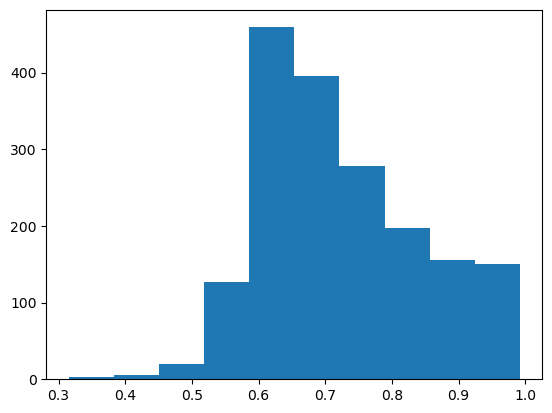

In [5]:
raw_data=np.load('./wsc.npy')
ok_list=[sqi(raw_data[idx,6:],r_peaks(raw_data[idx,6:])) for idx in range(len(raw_data))]
sqi_list=[ok_tuple[1] for ok_tuple in ok_list]
pass_list=[ok_tuple[0] for ok_tuple in ok_list]
deep_clean_data=raw_data[pass_list]
with open('wsc_0.6.npy','xb') as f:
    np.save(f,deep_clean_data)
plt.hist(sqi_list)

In [79]:
dic_list=[]
for idx in range(len(cleaned_wake_ecg)):
    peaks=simple_qrs_detector(cleaned_wake_ecg[idx,3:],fs=200)
    fineturned_r=R_Wave_finetune(cleaned_wake_ecg[idx,3:],peaks)
    td_data=td.hrv(fineturned_r,sampling_rate=200).__dict__
    fd_data=fd.frequencies(fineturned_r,200).__dict__
    poincare_data=nl.poincare(fineturned_r, 200).__dict__
    entropy_data=nl.entropy(fineturned_r, 200).__dict__
    all_dict=dict(**td_data,**fd_data,**poincare_data,**entropy_data)
    all_dict['ahi']=cleaned_wake_ecg[idx,1]
    all_dict['anno']=cleaned_wake_ecg[idx,2]
    dic_list.append(all_dict)

/home/linzenghui/ECG_code/HeartRateVariability_220217/fractal_higuchi.py:195: UserWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. HFD is returned for kmax value of 20.
  warn(
/home/linzenghui/ECG_code/HeartRateVariability_220217/fractal_higuchi.py:195: UserWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. HFD is returned for kmax value of 20.
  warn(
/home/linzenghui/ECG_code/HeartRateVariability_220217/fractal_higuchi.py:195: UserWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. HFD is returned for kmax value of 20.
  warn(
/home/linzenghui/ECG_code/HeartRateVariability_220217/fractal_higuchi.py:195: UserWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by

In [80]:
map=['ahi','anno','sdnn', 'sdann_1', 'sdnni_1', 'rmssd', 'sdsd', 'cvnn',
       'cvsd', 'pNN20', 'pNN50', 'tri_index', 'tinn_m', 'tinn_n', 'tinn',
       'vlf_power', 'lf_power', 'hf_power', 'vhf_power', 'total_power', 'lf_n',
       'hf_n', 'lf_hf', 'sd1', 'sd2', 'sd1_sd2', 's', 'csi', 'cvi',
       'csi_modified', 'approximate', 'sample', 'shannon', 'fuzzy', 'cd',
       'hfd', 'kfd', 'lzc']

In [81]:
df_hrv=pd.DataFrame(dic_list)[map]
normal_df=df_hrv[df_hrv['anno']==0]
abnormal_df=df_hrv[df_hrv['anno']==1]

In [82]:
p_value={}
for column in normal_df.columns[2:38]:
    P=stats.ranksums(normal_df[column],abnormal_df[column])[1]
    p_value[column]=P
index=['wsc']
pd.DataFrame(p_value,index=index).to_excel('wsc.xlsx')

In [24]:
train_names,test_names=my_random_split(new_names,len=[1800,770],shuffle=True)
train_names.sort()
test_names.sort()
train_raw_data=get_wake_ecg_from_edf(train_names,bag_path='../polysomnography/',datasetnumber=5)
train_data=cut_data(train_raw_data,datasetnumber=5)
test_raw_data=get_wake_ecg_from_edf(test_names,bag_path='../polysomnography/',datasetnumber=5)
test_data=cut_data(test_raw_data,datasetnumber=5)

In [32]:
with open('wsc_train_30s.npy','xb') as f:
    np.save(f,train_data)
with open('wsc_test_30s.npy','xb') as f:
    np.save(f,test_data)